
Збіжність MP2 енергії Ne від базису
Базис        N_bas  E(HF)           E(MP2)          E_corr, mHa 
----------------------------------------------------------------------
cc-pvdz          14   -128.48877555   -128.67634274    -187.5672
cc-pvtz          30   -128.53186164   -128.80915324    -277.2916
cc-pvqz          55   -128.54346966   -128.86972810    -326.2584
cc-pv5z          91   -128.54677013   -128.89287627    -346.1061

Екстраполяція до CBS:
E(HF/CBS):  -127.5183682662 Ha
E(MP2/CBS): -127.8615389677 Ha
E_corr(CBS): -343.1707 mHa


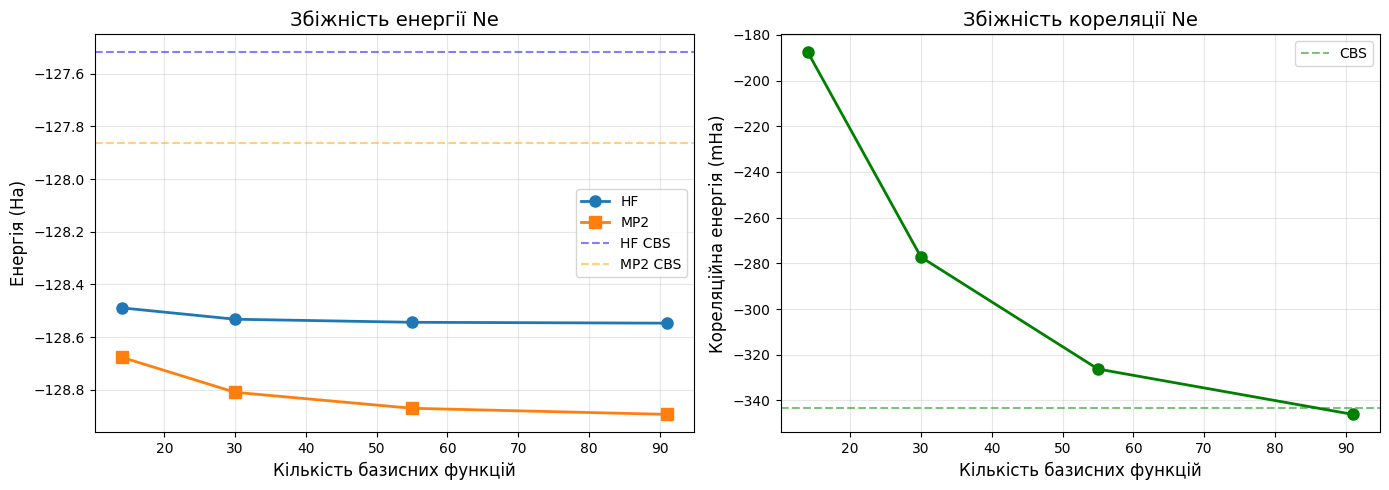


Збіжність MP2 енергії C від базису
Базис        N_bas  E(HF)           E(MP2)          E_corr, mHa 
----------------------------------------------------------------------
cc-pvdz          14    -37.68654444    -37.73965543     -53.1110
cc-pvtz          30    -37.69156917    -37.76724007     -75.6709
cc-pvqz          55    -37.69330782    -37.78979075     -96.4829
cc-pv5z          91    -37.69367665    -37.79751943    -103.8428

Екстраполяція до CBS:
E(HF/CBS):  -37.3921241364 Ha
E(MP2/CBS): -37.4950744059 Ha
E_corr(CBS): -102.9503 mHa


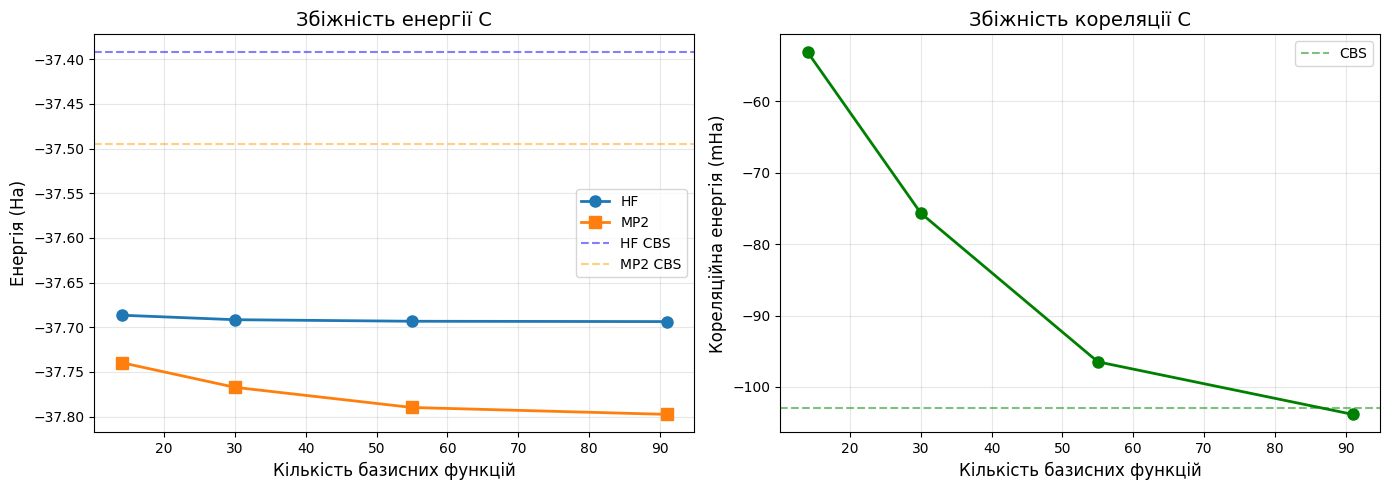

In [2]:
from pyscf import gto, scf, mp
import matplotlib.pyplot as plt

def mp2_basis_convergence(symbol, spin):
    """
    Дослідження збіжності MP2 від базису
    """
    
    basis_sets = ['cc-pvdz', 'cc-pvtz', 'cc-pvqz', 'cc-pv5z']
    
    print(f'\nЗбіжність MP2 енергії {symbol} від базису')
    print('='*70)
    print(f'{"Базис":12s} {"N_bas":6s} {"E(HF)":15s} {"E(MP2)":15s} '
          f'{"E_corr, mHa":12s}')
    print('-'*70)
    
    e_hf_list = []
    e_mp2_list = []
    e_corr_list = []
    n_bas_list = []
    
    for basis in basis_sets:
        mol = gto.M(
            atom=f'{symbol} 0 0 0',
            basis=basis,
            spin=spin,
            verbose=0
        )
        
        # HF
        if spin == 0:
            mf = scf.RHF(mol)
            mp_method = mp.MP2
        else:
            mf = scf.UHF(mol)
            mp_method = mp.UMP2
        
        mf.verbose = 0
        mf.conv_tol = 1e-11
        e_hf = mf.kernel()
        
        # MP2
        mymp2 = mp_method(mf)
        mymp2.verbose = 0
        e_corr, _ = mymp2.kernel()
        e_mp2 = e_hf + e_corr
        
        n_bas = mol.nao_nr()
        
        e_hf_list.append(e_hf)
        e_mp2_list.append(e_mp2)
        e_corr_list.append(e_corr)
        n_bas_list.append(n_bas)
        
        print(f'{basis:12s} {n_bas:6d} {e_hf:15.8f} {e_mp2:15.8f} '
              f'{e_corr*1000:12.4f}')
    
    print('='*70)
    
    # Екстраполяція до CBS
    # E(X) = E_CBS + A/X^3
    X = np.array([2, 3, 4, 5])  # D, T, Q, 5
    
    # CBS для HF (швидша збіжність)
    A_hf = (e_hf_list[-1]*5**3 - e_hf_list[-2]*4**3) / (5**3 - 4**3)
    e_hf_cbs = e_hf_list[-1] - A_hf / 5**3
    
    # CBS для кореляції
    A_corr = (e_corr_list[-1]*5**3 - e_corr_list[-2]*4**3) / (5**3 - 4**3)
    e_corr_cbs = e_corr_list[-1] - A_corr / 5**3
    
    e_mp2_cbs = e_hf_cbs + e_corr_cbs
    
    print(f'\nЕкстраполяція до CBS:')
    print(f'E(HF/CBS):  {e_hf_cbs:.10f} Ha')
    print(f'E(MP2/CBS): {e_mp2_cbs:.10f} Ha')
    print(f'E_corr(CBS): {e_corr_cbs*1000:.4f} mHa')
    
    # Графік
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Повна енергія
    ax1.plot(n_bas_list, e_hf_list, 'o-', label='HF', 
            linewidth=2, markersize=8)
    ax1.plot(n_bas_list, e_mp2_list, 's-', label='MP2', 
            linewidth=2, markersize=8)
    ax1.axhline(y=e_hf_cbs, color='blue', linestyle='--', 
               alpha=0.5, label='HF CBS')
    ax1.axhline(y=e_mp2_cbs, color='orange', linestyle='--', 
               alpha=0.5, label='MP2 CBS')
    ax1.set_xlabel('Кількість базисних функцій', fontsize=12)
    ax1.set_ylabel('Енергія (Ha)', fontsize=12)
    ax1.set_title(f'Збіжність енергії {symbol}', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Кореляційна енергія
    ax2.plot(n_bas_list, np.array(e_corr_list)*1000, 'o-', 
            linewidth=2, markersize=8, color='green')
    ax2.axhline(y=e_corr_cbs*1000, color='green', linestyle='--', 
               alpha=0.5, label='CBS')
    ax2.set_xlabel('Кількість базисних функцій', fontsize=12)
    ax2.set_ylabel('Кореляційна енергія (mHa)', fontsize=12)
    ax2.set_title(f'Збіжність кореляції {symbol}', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{symbol}_mp2_basis_convergence.pdf')
    plt.show()

# Приклади
mp2_basis_convergence('Ne', spin=0)
mp2_basis_convergence('C', spin=2)